## Import modules

In [1]:
import os
import numpy as np
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

slim = tf.contrib.slim
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(tf.__version__)

NUM_CLASSES = 10
NUM_PARALLEL_CALLS = 2 # number of cpu cores
BATCH_SIZE = 7
REPEAT_DATASET = 1

1.12.0


## Dataset setup

In [2]:
import mnist_reader
train_images, train_labels = mnist_reader.load_mnist('datasets/mnist', kind='train')
test_images, test_labels = mnist_reader.load_mnist('datasets/mnist', kind='t10k')

In [3]:
print("\n-------------------------------")
print("train_images shape: " + str(train_images.shape))
print("train_labels shape: " + str(train_labels.shape))
print("valid_images shape: " + str(test_images.shape))
print("valid_labels shape: " + str(test_labels.shape))
print("-------------------------------\n")


-------------------------------
train_images shape: (60000, 28, 28, 1)
train_labels shape: (60000,)
valid_images shape: (10000, 28, 28, 1)
valid_labels shape: (10000,)
-------------------------------



In [4]:
# create the training datasets
dx_train = tf.data.Dataset.from_tensor_slices(train_images)

# apply a one-hot transformation to each label for use in the neural network
dy_train = tf.data.Dataset.from_tensor_slices(train_labels)
dy_train = dy_train.map(lambda z: tf.one_hot(z, 10), num_parallel_calls=NUM_PARALLEL_CALLS)
dy_train = dy_train.repeat()

# zip the x and y training data together and shuffle, batch etc.
train_dataset = tf.data.Dataset.zip((dx_train, dy_train)).shuffle(500)
train_dataset = train_dataset.repeat(REPEAT_DATASET)
train_dataset = train_dataset.batch(BATCH_SIZE)

# do the same for validation set
dx_valid = tf.data.Dataset.from_tensor_slices(test_images)
dy_valid = tf.data.Dataset.from_tensor_slices(test_labels)
dy_valid = dy_valid.map(lambda z: tf.one_hot(z, 10), num_parallel_calls=NUM_PARALLEL_CALLS)
dy_valid = dy_valid.repeat()

test_dataset = tf.data.Dataset.zip((dx_valid, dy_valid)).shuffle(500)
test_dataset = test_dataset.repeat(REPEAT_DATASET)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [5]:
# create general iterator
iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                            train_dataset.output_shapes)
next_batch = iterator.get_next()

# make datasets that we can initialize separately, but using the same structure via the common iterator
training_init_op = iterator.make_initializer(train_dataset)
test_init_op = iterator.make_initializer(test_dataset)

## Model setup

In [6]:
with tf.name_scope('input'):
    input_images = tf.placeholder(tf.float32, shape=(None,28,28,1), name='input_images')
    labels = tf.placeholder(tf.int64, shape=(None, NUM_CLASSES), name='labels')
    
global_step = tf.Variable(0, trainable=False, name='global_step')


def parametric_relu(_x):
  alphas = tf.get_variable('alpha', _x.get_shape()[-1],
                       initializer=tf.constant_initializer(0.0),
                        dtype=tf.float32)
  pos = tf.nn.relu(_x)
  neg = alphas * (_x - abs(_x)) * 0.5

  return pos + neg


def inference(input_images):
    with slim.arg_scope([slim.conv2d], kernel_size=3, padding='SAME'):
        with slim.arg_scope([slim.max_pool2d], kernel_size=2):
            
            x = slim.conv2d(input_images, num_outputs=32, scope='conv1_1')
            x = slim.conv2d(x, num_outputs=32, scope='conv1_2')
            x = slim.max_pool2d(x, scope='pool1')
     
            x = slim.conv2d(x, num_outputs=64, scope='conv2_1')
            x = slim.conv2d(x, num_outputs=64, scope='conv2_2')
            x = slim.max_pool2d(x, scope='pool2')
            
            x = slim.conv2d(x, num_outputs=128, scope='conv3_1')
            x = slim.conv2d(x, num_outputs=128, scope='conv3_2')
            x = slim.max_pool2d(x, scope='pool3')
            
            x = slim.flatten(x, scope='flatten')
            
            features3d = slim.fully_connected(x, num_outputs=3, activation_fn=None, scope='fc0')
            features2d = slim.fully_connected(features3d, num_outputs=2, activation_fn=None, scope='fc1')

            x = parametric_relu(features3d)
            x = slim.fully_connected(x, num_outputs=10, activation_fn=None, scope='fc2')
    
    return x, features2d, features3d

In [7]:
CENTER_LOSS_ALPHA = 0.5

def get_center_loss(features, labels, alpha, num_classes):
    """Get the update of center loss and center op
    
    Arguments:
        features: Tensor,To characterize the sample features, generally use the output of an fc layer, the shape should be [batch_size, feature_length].
        labels: Tensor, characterizing the sample label, non-one-hot encoding, shape should be [batch_size].
        alpha: A number between 0-1 that controls the learning rate at the center of the sample category. See the original for details.
        num_classes: An integer indicating how many categories are in total, and how many neurons are output from the network classification.
    
    Return：
        loss: Tensor, which can be added as a total loss with softmax loss.
        centers: Tensor, a Tensor that stores sample center values, is useful only for viewing specific values stored in the sample center.
        centers_update_op: op, used to update the op in the sample center. You need to run the op at the same time during training, otherwise the sample center will not be updated.
    """
    # Get the dimension of the feature, such as 256 dimensions
    len_features = features.get_shape()[1]
    
    # Create a Variable with a shape of [num_classes, len_features] to store the sample center of the entire network.
    # Set trainable=False because the sample center is not updated by the gradient
    centers = tf.get_variable('centers', [num_classes, len_features], dtype=tf.float32,
        initializer=tf.constant_initializer(0), trainable=False)

    # Expand the label to one-dimensional, if the input is already one-dimensional action is not needed.
    labels = tf.reshape(labels, [-1])
    
    # Get the center value corresponding to each sample in the mini-batch according to the sample label
    centers_batch = tf.gather(centers, labels)
    # Calculate loss
    loss = tf.nn.l2_loss(features - centers_batch)
    
    # The difference between the current eigenvalues of mini-batch and their corresponding center values
    diff = centers_batch - features
    
    # Get the number of occurrences of the same category of samples in mini-batch. 
    # For the principle, please refer to the original formula (4).
    unique_label, unique_idx, unique_count = tf.unique_with_counts(labels)
    appear_times = tf.gather(unique_count, unique_idx)
    appear_times = tf.reshape(appear_times, [-1, 1])
    
    diff = diff / tf.cast((1 + appear_times), tf.float32)
    diff = alpha * diff
    
    centers_update_op = tf.scatter_sub(centers, labels, diff)
    
    return loss, centers, centers_update_op


In [8]:
def loss(logits, features, labels, ratio=0.5):
    with tf.name_scope('loss'):
        with tf.name_scope('center_loss'):
            label_non_one_hot = tf.argmax(labels, 1)
            center_loss, centers, centers_update_op = get_center_loss(features, label_non_one_hot, CENTER_LOSS_ALPHA, NUM_CLASSES)        
        with tf.name_scope('softmax_loss'):
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits))

        with tf.name_scope('total_loss'):
            softmax_loss_index = tf.cast(softmax_loss, tf.float32)
            total_loss = softmax_loss_index + ratio * center_loss            

    with tf.name_scope('loss/'):
        tf.summary.scalar('SoftmaxLoss', softmax_loss)
        tf.summary.scalar('CenterLoss', center_loss)
        tf.summary.scalar('TotalLoss', total_loss)
        
    return total_loss, centers_update_op

def accuracy(labels):
    with tf.name_scope('acc'):
        prediction = tf.argmax(logits, 1)        
        equality = tf.equal(prediction, tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))
    return accuracy

In [9]:
logits, features2d, features3d = inference(input_images)
loss, centers_update_op = loss(logits, features3d, labels)
accuracy = accuracy(labels)

In [10]:
with tf.control_dependencies([centers_update_op]):
    optimizer = tf.train.AdamOptimizer(0.001).minimize(loss, global_step=global_step)

In [11]:
# prediction = tf.argmax(logits, 1)
init_op = tf.global_variables_initializer()
summary_op = tf.summary.merge_all()

## Training the model

In [12]:
mean_data = np.mean(train_images, axis=0)

In [13]:
from tensorflow.python import debug as tf_debug

# run the training
epochs = 8000
sess = tf.Session()
# sess = tf_debug.TensorBoardDebugWrapperSession(sess, "Eugenes-MBP:7000")
# Start Tensorflow from this file 'tensorboard --logdir=/tmp/mnist_log --debugger_port 7000'

sess.run(tf.global_variables_initializer())
sess.run(init_op)
sess.run(training_init_op)

writer = tf.summary.FileWriter('/tmp/mnist_log', sess.graph)
# Start Tensorflow from this file 'tensorboard --logdir=/tmp/mnist_log'

for i in range(epochs):

    img_batch, label_batch = sess.run(next_batch)
    l, _, acc, summary_str = sess.run([loss, optimizer, accuracy, summary_op],
                                         feed_dict={input_images: img_batch-mean_data,labels: label_batch})

    writer.add_summary(summary_str, global_step=epochs)

    if i % 50 == 0:
        print("Epoch: {}, loss: {:.3f}, training accuracy: {:.2f}%".format(i, l, acc * 100)) 



# now setup the validation run
test_iters = 100
# re-initialize the iterator, but this time with validation data
sess.run(test_init_op)
avg_acc = 0
for i in range(test_iters):
    img_batch, label_batch = sess.run(next_batch)
    acc = sess.run([accuracy], feed_dict={input_images: img_batch-mean_data,labels: label_batch})
    avg_acc += acc[0]
print("Average validation set accuracy over {} iterations is {:.2f}%".format(test_iters, (avg_acc / test_iters) * 100))


Epoch: 0, loss: 2.305, training accuracy: 14.29%
Epoch: 50, loss: 2.301, training accuracy: 14.29%
Epoch: 100, loss: 2.249, training accuracy: 0.00%
Epoch: 150, loss: 2.215, training accuracy: 42.86%
Epoch: 200, loss: 2.200, training accuracy: 28.57%
Epoch: 250, loss: 2.029, training accuracy: 14.29%
Epoch: 300, loss: 2.053, training accuracy: 42.86%
Epoch: 350, loss: 2.259, training accuracy: 28.57%
Epoch: 400, loss: 1.805, training accuracy: 71.43%
Epoch: 450, loss: 1.869, training accuracy: 42.86%
Epoch: 500, loss: 2.351, training accuracy: 14.29%
Epoch: 550, loss: 2.008, training accuracy: 28.57%
Epoch: 600, loss: 1.678, training accuracy: 85.71%
Epoch: 650, loss: 1.802, training accuracy: 57.14%
Epoch: 700, loss: 1.664, training accuracy: 71.43%
Epoch: 750, loss: 1.707, training accuracy: 42.86%
Epoch: 800, loss: 1.548, training accuracy: 71.43%
Epoch: 850, loss: 1.439, training accuracy: 71.43%
Epoch: 900, loss: 1.306, training accuracy: 71.43%
Epoch: 950, loss: 1.489, training a

Epoch: 7800, loss: 0.368, training accuracy: 85.71%
Epoch: 7850, loss: 0.085, training accuracy: 100.00%
Epoch: 7900, loss: 0.074, training accuracy: 100.00%
Epoch: 7950, loss: 0.084, training accuracy: 100.00%
Average validation set accuracy over 100 iterations is 97.43%


## Visualize train_data

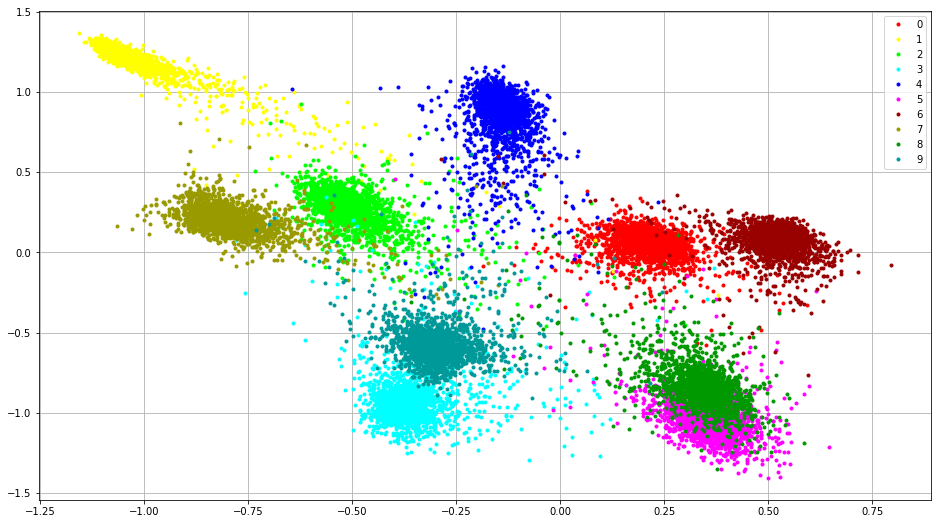

In [14]:
feat = sess.run(features2d, feed_dict={input_images:train_images[:20000]-mean_data})

%matplotlib inline
import matplotlib.pyplot as plt

labels = train_labels[:20000]

f = plt.figure(figsize=(16,9))
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', 
     '#ff00ff', '#990000', '#999900', '#009900', '#009999']
for i in range(10):
    plt.plot(feat[labels==i,0].flatten(), feat[labels==i,1].flatten(), '.', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

plt.grid()
plt.show()

### Visualize test_data

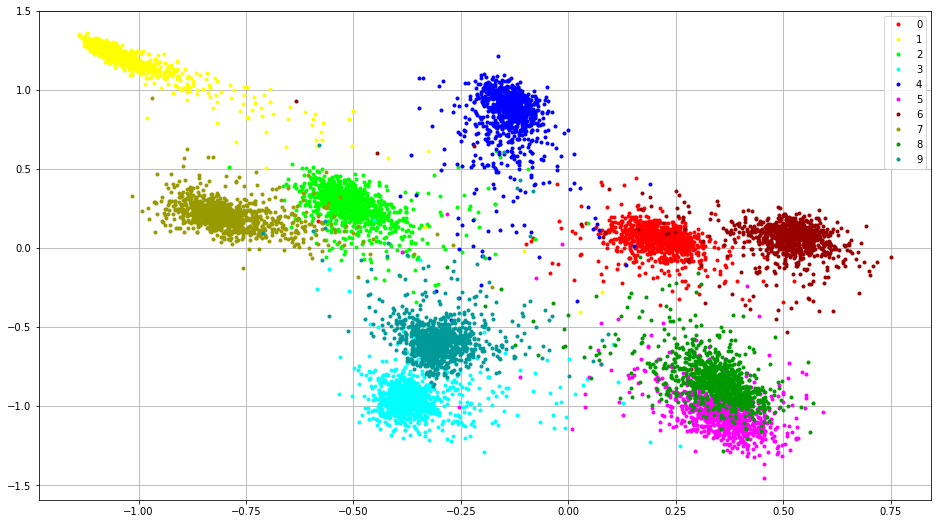

In [15]:
feat = sess.run(features2d, feed_dict={input_images:test_images[:20000]-mean_data})

%matplotlib inline
import matplotlib.pyplot as plt

labels = test_labels[:20000]

f = plt.figure(figsize=(16,9))
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', 
     '#ff00ff', '#990000', '#999900', '#009900', '#009999']
for i in range(10):
    plt.plot(feat[labels==i,0].flatten(), feat[labels==i,1].flatten(), '.', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.grid()
plt.show()

### Visualize train_data 3D

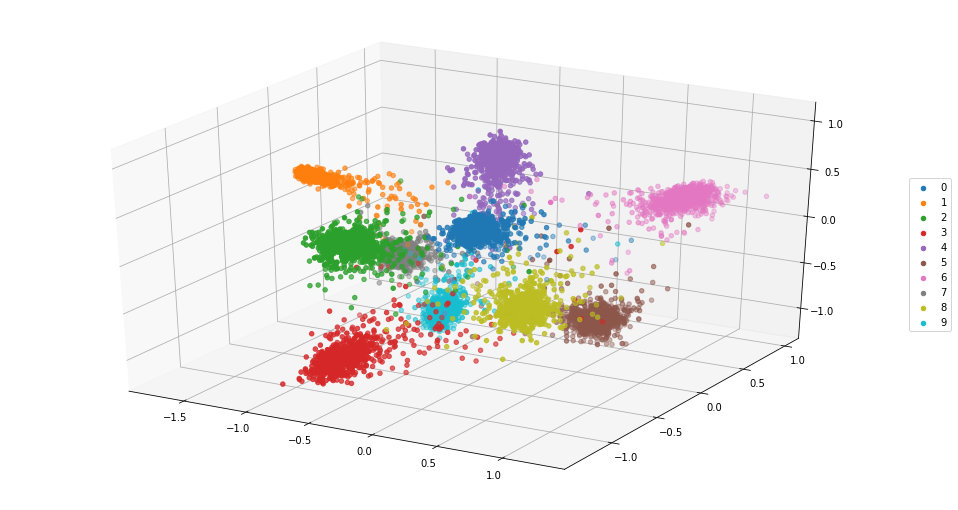

In [16]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

feat = sess.run(features3d, feed_dict={input_images:train_images[:10000]-mean_data})
labels = train_labels[:10000]

fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')

for i in range(10):
    # Data for three-dimensional scattered points
    xdata = feat[labels==i,2].flatten()
    ydata = feat[labels==i,0].flatten()
    zdata = feat[labels==i,1].flatten()
    ax.scatter3D(xdata, ydata, zdata);
ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Visualize test_data 3D

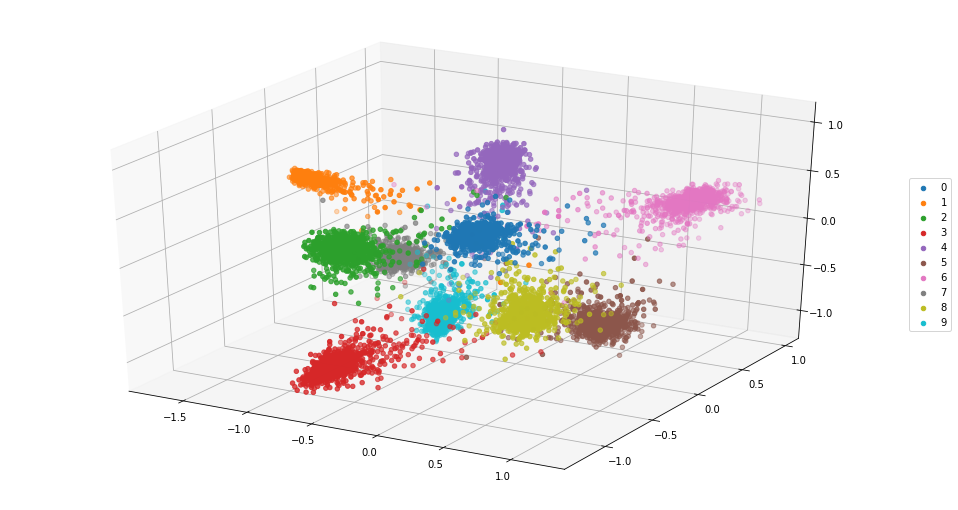

In [17]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

feat = sess.run(features3d, feed_dict={input_images:test_images[:10000]-mean_data})
labels = test_labels[:10000]

fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')

for i in range(10):
    # Data for three-dimensional scattered points
    xdata = feat[labels==i,2].flatten()
    ydata = feat[labels==i,0].flatten()
    zdata = feat[labels==i,1].flatten()
    ax.scatter3D(xdata, ydata, zdata);
ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [18]:
sess.close()